In [2]:
import numpy as np
# import pandas as pd
import scanpy as sc
import seaborn as sb
import matplotlib.pyplot as plt
# from matplotlib import rcParams
%matplotlib inline
# import seaborn as sns
import scipy.sparse
# import cmasher as cmr
# from natsort import natsorted
import sys 
import os
import joblib
# from imblearn.over_sampling import SMOTE
# from collections import Counter
# import sc_module as sm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# from collections import OrderedDict
# import decoupler as dc

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 pynndescent==0.5.13


In [3]:
sys.path.append(os.path.abspath(r"C:\\Users\\bence\\Projects\\BIO446\\McKinnon-Rosati-Laboratory\\Project 2\\jl_modules"))

In [4]:
clustered_file = "C:\\Users\\bence\\Projects\\BIO446\\McKinnon-Rosati-Laboratory\\Project 1\\granulomas_final.h5ad"

In [5]:
# clustered data
adata = sc.read_h5ad(clustered_file)
adata.uns['log1p']["base"] = None # bug fix

print(adata.obs['sample'].value_counts())
print()
print('X matrix is sparse:', scipy.sparse.issparse(adata.X))
print('X size =', adata.X.shape)

sample
granuloma2    9392
granuloma1    9302
granuloma3    8909
Name: count, dtype: int64

X matrix is sparse: False
X size = (27603, 23693)


In [6]:
adata

AnnData object with n_obs × n_vars = 27603 × 23693
    obs: 'scDblFinder_score', 'scDblFinder_class', 'doublet', 'n_genes_by_counts', 'total_counts', 'type', 'sample', 'batch_type', 'batch', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'size_factors', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1.0', 'leiden_1.4', 'leiden_1.7', 'leiden_2.0', 'leiden_2.5', 'leiden_3.0', 'leiden_3.5', 'leiden_4.0', 'leiden_4.5', 'hclust', 'kmeans', 'my_clust_1', 'immune', 'mesothelial', 'stromal', 'endothelial', 'epithelial', 'muscle', 'Immune', 'Myeloid', 'Lymphoid', 'Mesenchyme', 'Mesothelial', 'Stromal', 'SMC', 'Endothelial', 'Blood vessels', 'LEC', 'Epithelial', 'Ciliated', 'Secretory'
    var: 'gene_ids', 'fe

In [7]:
cluster_type = 'my_clust_1'

In [8]:
adata.obs[cluster_type]

AAACCTGAGCGTAGTG_sc69_1     6
AAACCTGAGCTGATAA_sc69_1     3
AAACCTGCAAATCCGT_sc69_1     4
AAACCTGCAAGGGTCA_sc69_1    13
AAACCTGCACATCCGG_sc69_1     4
                           ..
TTTGTCAGTTCAACCA_sc72_1     4
TTTGTCAGTTCAGTAC_sc72_1     8
TTTGTCATCACAAACC_sc72_1     4
TTTGTCATCAGCACAT_sc72_1     4
TTTGTCATCTCGAGTA_sc72_1    22
Name: my_clust_1, Length: 27603, dtype: category
Categories (30, object): ['0', '10', '11', '11b', ..., '7c', '8', '9', '9b']

In [9]:
annotation_dict= {
'9': 'CAP1',
'24': 'CAP2',
'9b': 'VEC',
'27': 'LEC',
    
'17': 'Ciliated',
'15': 'Secretory',
'22': 'AT1',
'6': 'AT2',
'12': 'AT2-t1',
'19': 'AT2-t2',
    
'14': 'AF',
'25': 'Pericyte',
    
'20': 'Mesothelial',
    
'3': 'B1',
'3b': 'B2',
    
'0': 'Th1',
'8': 'Tnaive',
'11': 'Tex',
'77': 'Treg',
    
'11b': 'NK',
    
'4a': 'AM',
'4': 'M-t1',
'10': 'M-lc',
'7': 'M-t2',
'7b': 'M-C1q',
'7c': 'iMon',
    
'23': 'pDC',
'13': 'DC',
'5b': 'N1',
'5': 'N2',
}

In [10]:
# Add cell type column based on annotation
adata.obs['cell_type_edit'] = [annotation_dict[clust] for clust in adata.obs[cluster_type]]

# Error checking
dict_list = list(annotation_dict.keys())
adata_list = list(adata.obs['my_clust_1'].unique())
print('Keys in dictionary not in adata:', [item for item in dict_list if item not in adata_list] )
print('Keys in adata not in dictionary:', [item for item in adata_list if item not in dict_list] )

Keys in dictionary not in adata: []
Keys in adata not in dictionary: []


In [11]:
adata.obs['cell_type_edit']

AAACCTGAGCGTAGTG_sc69_1       AT2
AAACCTGAGCTGATAA_sc69_1        B1
AAACCTGCAAATCCGT_sc69_1      M-t1
AAACCTGCAAGGGTCA_sc69_1        DC
AAACCTGCACATCCGG_sc69_1      M-t1
                            ...  
TTTGTCAGTTCAACCA_sc72_1      M-t1
TTTGTCAGTTCAGTAC_sc72_1    Tnaive
TTTGTCATCACAAACC_sc72_1      M-t1
TTTGTCATCAGCACAT_sc72_1      M-t1
TTTGTCATCTCGAGTA_sc72_1       AT1
Name: cell_type_edit, Length: 27603, dtype: object

In [12]:
# collect unique cells
unique_celltype_sub = adata.obs['cell_type_edit'].unique()
print(unique_celltype_sub)

# count num unique cells
num_unique_celltype_sub = adata.obs['cell_type_edit'].nunique()
print(f"Number of unique sub cell types: {num_unique_celltype_sub}")

['AT2' 'B1' 'M-t1' 'DC' 'Th1' 'M-t2' 'Secretory' 'AM' 'N1' 'M-C1q'
 'AT2-t2' 'AF' 'VEC' 'CAP1' 'N2' 'AT2-t1' 'Pericyte' 'pDC' 'Ciliated' 'NK'
 'AT1' 'Tnaive' 'Treg' 'M-lc' 'Mesothelial' 'Tex' 'CAP2' 'LEC' 'iMon' 'B2']
Number of unique sub cell types: 30


In [13]:
# map cell types to integers
replacement_dict = {
    'AT2': 0,
    'B1': 1,
    'M-t1': 2,
    'DC': 3,
    'Th1': 4,
    'M-t2': 5,
    'Secretory': 6,
    'AM': 7,
    'N1': 8,
    'M-C1q': 9,
    'AT2-t2': 10,
    'AF': 11,
    'VEC': 12,
    'CAP1': 13,
    'N2': 14,
    'AT2-t1': 15,
    'Pericyte': 16,
    'pDC': 17,
    'Ciliated': 18,
    'NK': 19,
    'AT1': 20,
    'Tnaive': 21,
    'Treg': 22,
    'M-lc': 23,
    'Mesothelial': 24,
    'Tex': 25,
    'CAP2': 26,
    'LEC': 27,
    'iMon': 28,
    'B2': 29
}

In [15]:
adata.obs['cell_type_edit2'] = adata.obs['cell_type_edit']
adata.obs['celltype'] = adata.obs['cell_type_edit'].replace(replacement_dict)

C:\Users\bence\AppData\Local\Temp\ipykernel_190232\1594719242.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs['celltype'] = adata.obs['cell_type_edit'].replace(replacement_dict)


In [16]:
adata.obs['celltype']

AAACCTGAGCGTAGTG_sc69_1     0
AAACCTGAGCTGATAA_sc69_1     1
AAACCTGCAAATCCGT_sc69_1     2
AAACCTGCAAGGGTCA_sc69_1     3
AAACCTGCACATCCGG_sc69_1     2
                           ..
TTTGTCAGTTCAACCA_sc72_1     2
TTTGTCAGTTCAGTAC_sc72_1    21
TTTGTCATCACAAACC_sc72_1     2
TTTGTCATCAGCACAT_sc72_1     2
TTTGTCATCTCGAGTA_sc72_1    20
Name: celltype, Length: 27603, dtype: int64

In [17]:
print("Unique values in 'celltype' column after replacement:", adata.obs['celltype'].unique())

Unique values in 'celltype' column after replacement: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [18]:
# number of cells in each cell type
cell_type_counts = adata.obs['cell_type_edit2'].value_counts()

print("Number of cells in each cell type:")
print(cell_type_counts)

Number of cells in each cell type:
cell_type_edit2
M-t1           5692
Th1            3420
B1             2068
AT2            1821
N2             1819
Tnaive         1226
M-lc           1162
M-t2           1094
AF             1091
AM              996
AT2-t1          871
DC              774
CAP1            740
Secretory       696
VEC             439
Ciliated        401
AT2-t2          379
Mesothelial     362
M-C1q           357
AT1             340
Tex             296
pDC             286
NK              251
CAP2            213
Treg            203
N1              160
B2              140
Pericyte        138
iMon            111
LEC              57
Name: count, dtype: int64


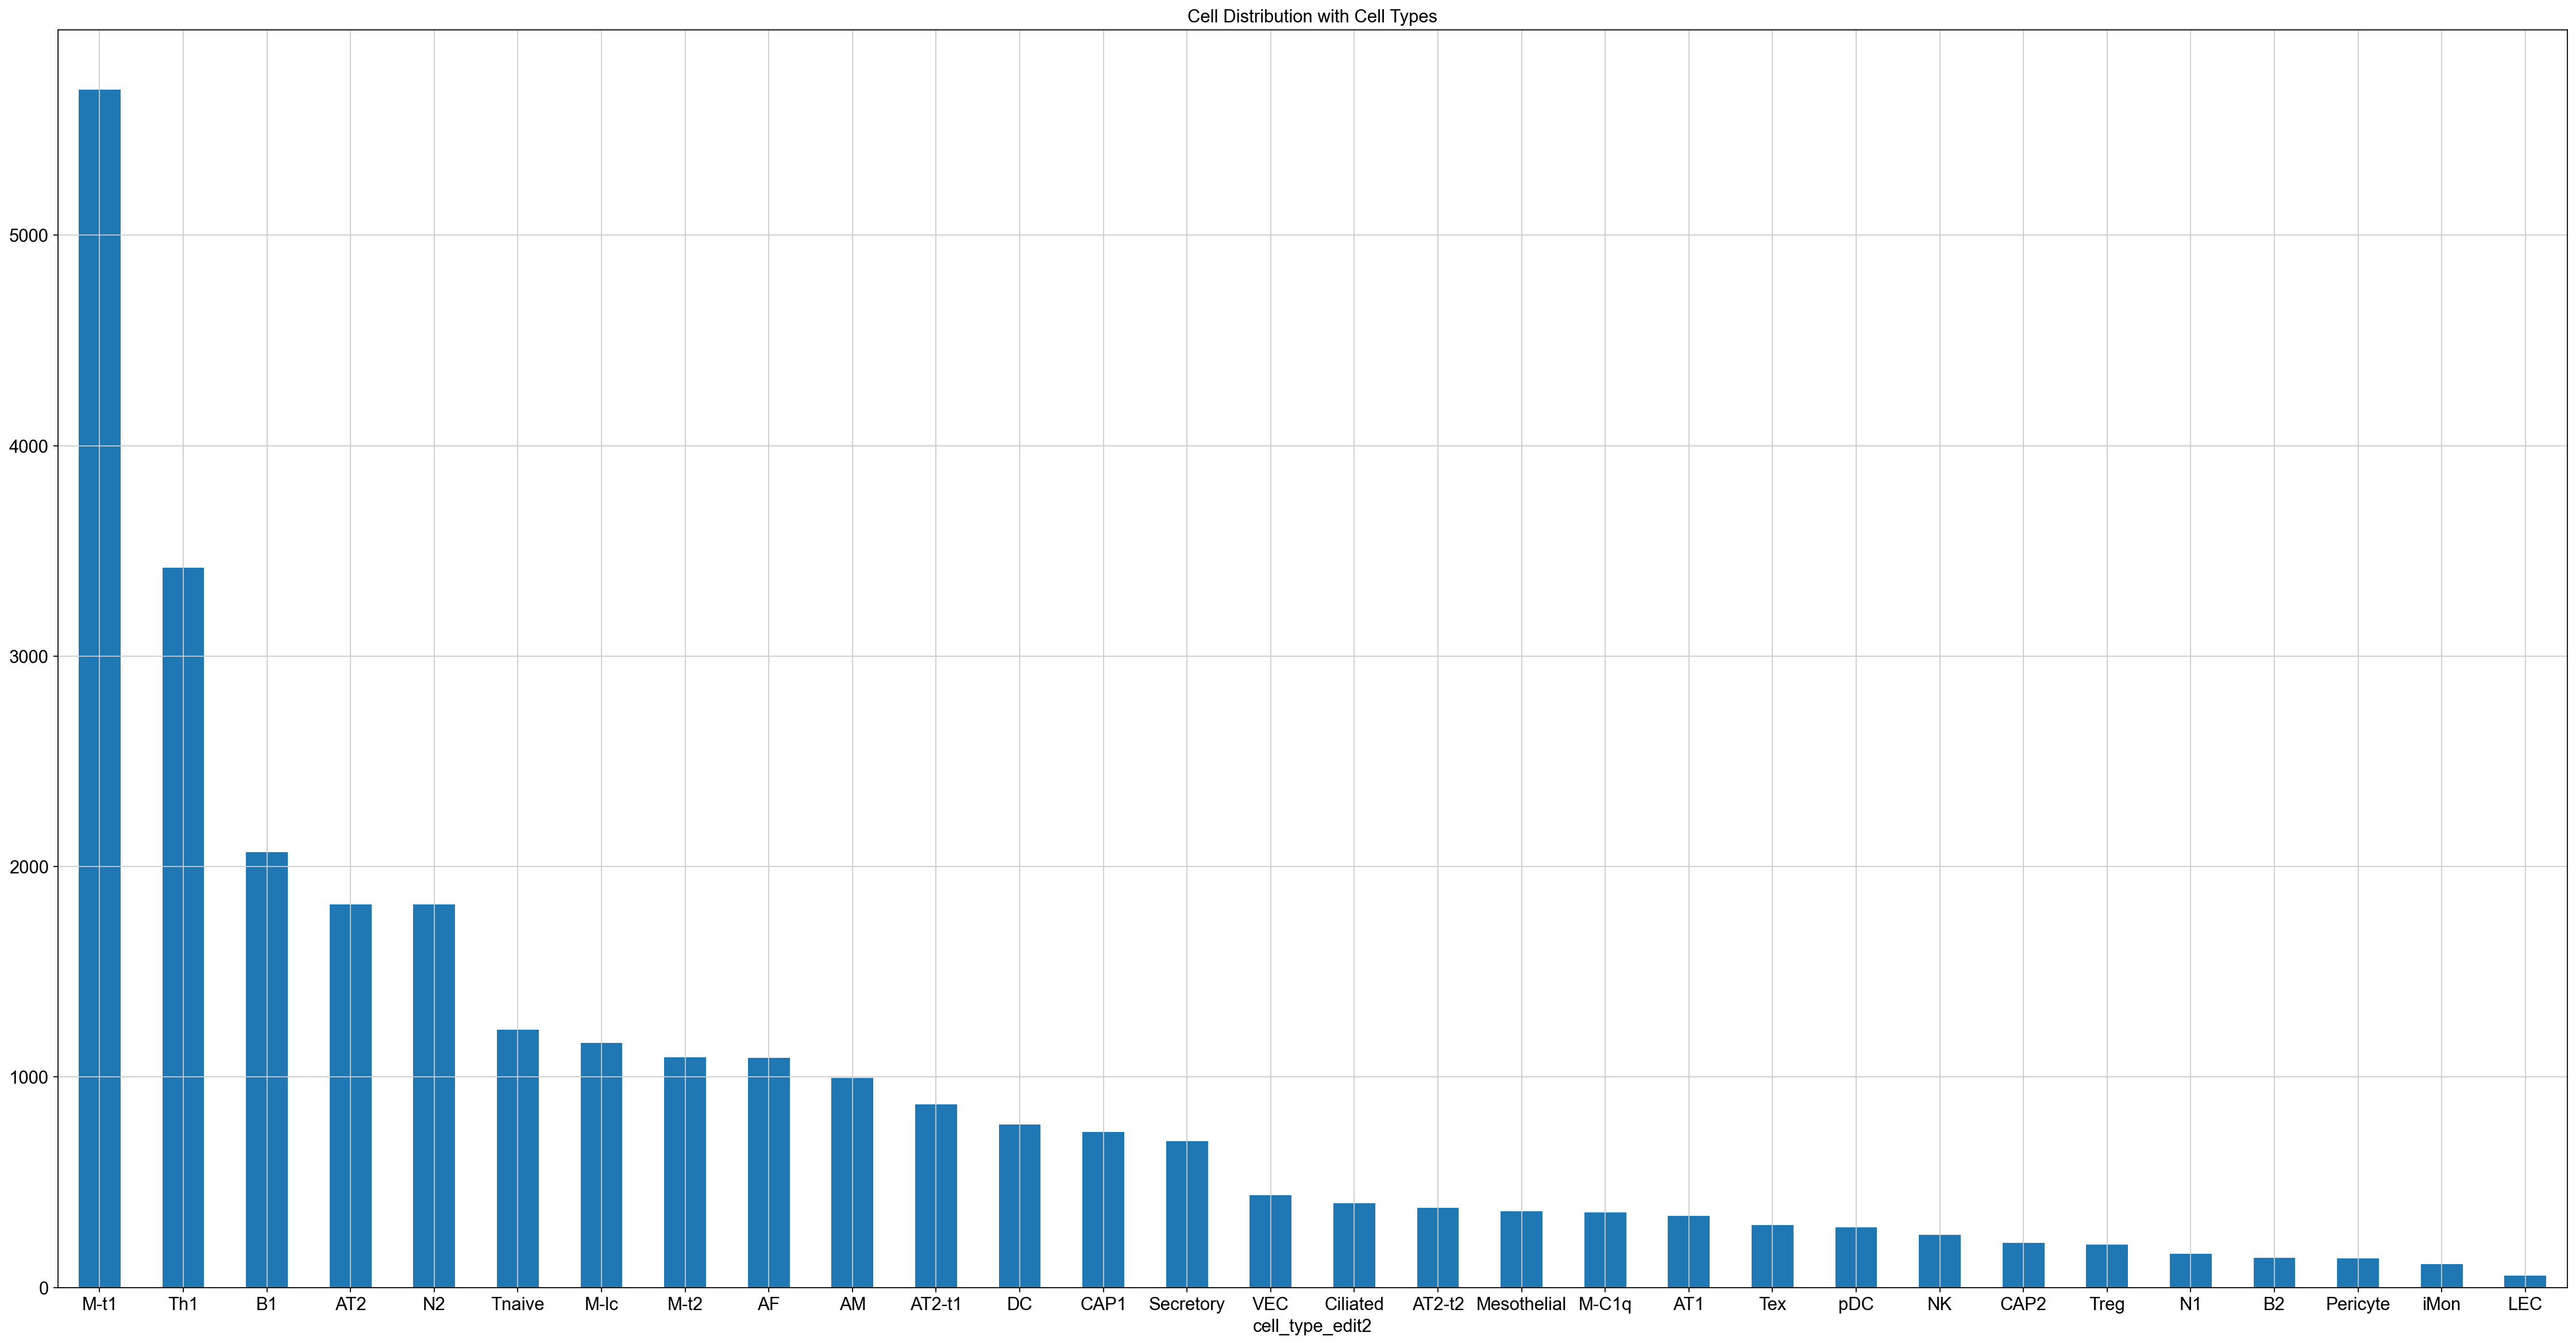

In [19]:
# cell distribution with cell types (hard to see)
y = adata.obs['cell_type_edit2']
plt.figure(figsize=(35, 18))
plt.title('Cell Distribution with Cell Types')
y.value_counts().plot(kind='bar', rot=0)
plt.show()

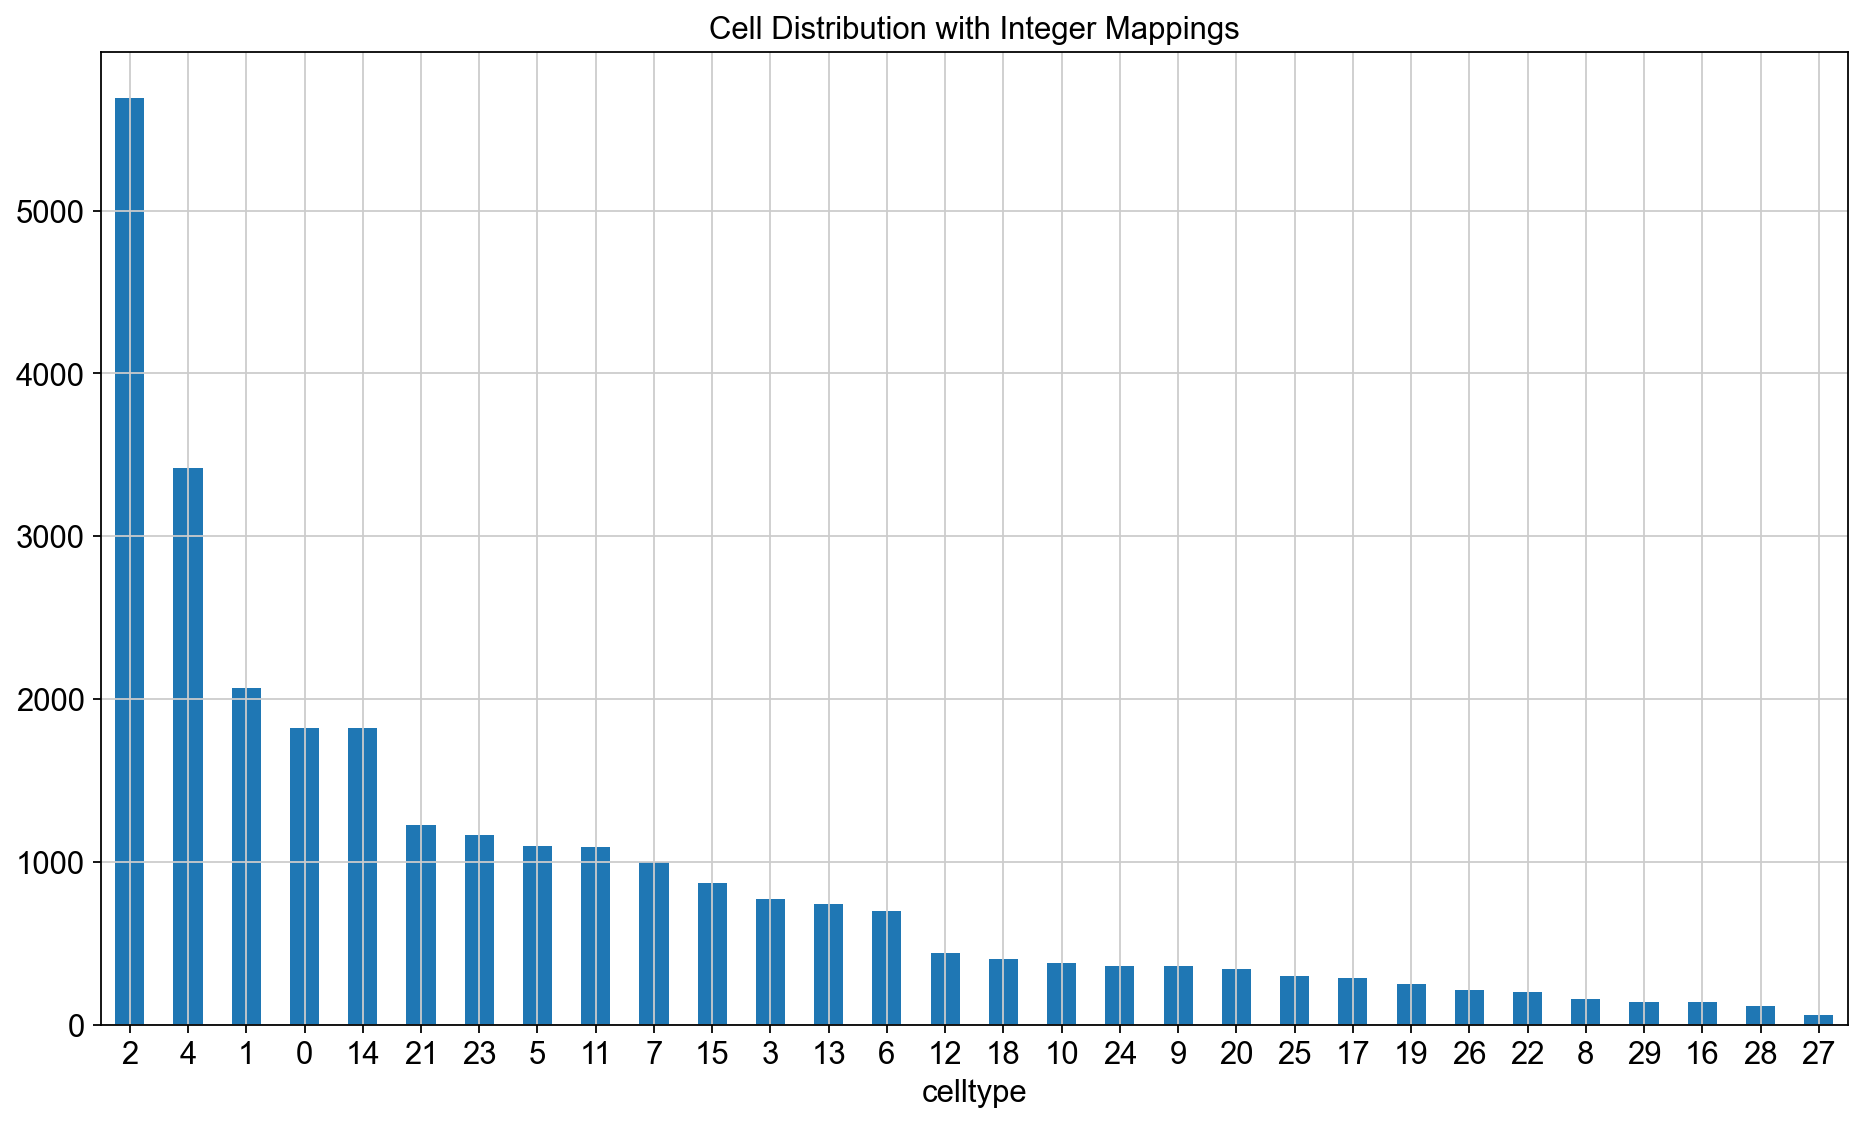

In [20]:
# cell distribution with int mappings (easy to see)
y = adata.obs['celltype']
plt.figure(figsize=(14, 8))
plt.title('Cell Distribution with Integer Mappings')
y.value_counts().plot(kind='bar', rot=0)
plt.show()

In [21]:
# Extract gene expression values (X) and cell types (y) from the adata object
# If adata.X is already a numpy array, just use it directly

X = adata.X  # No need for .toarray() if it's already a numpy array
y = adata.obs['celltype'].values  # Extract the cell types as a numpy array

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state=19)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size = 0.25, random_state=30)

train_features = np.array(train_features)
test_features = np.array(test_features)
val_features = np.array(val_features)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

# Print the shape of the training and testing sets
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (16561, 23693)
Validation features shape: (5521, 23693)
Test features shape: (5521, 23693)
Training labels shape: (16561,)
Validation labels shape: (5521,)
Test labels shape: (5521,)


In [25]:
# for compute cluster
np.save('../Arrays/train_features.npy', train_features)
np.save('../Arrays/test_features.npy', test_features)
np.save('../Arrays/val_features.npy', val_features)
np.save('../Arrays/train_labels.npy', train_labels)
np.save('../Arrays/test_labels.npy', test_labels)
np.save('../Arrays/val_labels.npy', val_labels)

In [26]:
print(y)
print(len(y))

[ 0  1  2 ...  2  2 20]
27603


In [27]:
print(X)
print(len(X))

[[0.         0.         0.         ... 0.         0.         0.65802306]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.9530956 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.40804082]
 [0.         0.         0.         ... 0.         0.39723676 1.0820873 ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
27603


In [28]:
adata.obs['celltype']

AAACCTGAGCGTAGTG_sc69_1     0
AAACCTGAGCTGATAA_sc69_1     1
AAACCTGCAAATCCGT_sc69_1     2
AAACCTGCAAGGGTCA_sc69_1     3
AAACCTGCACATCCGG_sc69_1     2
                           ..
TTTGTCAGTTCAACCA_sc72_1     2
TTTGTCAGTTCAGTAC_sc72_1    21
TTTGTCATCACAAACC_sc72_1     2
TTTGTCATCAGCACAT_sc72_1     2
TTTGTCATCTCGAGTA_sc72_1    20
Name: celltype, Length: 27603, dtype: int64

In [29]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train_labels
)

In [30]:
sample_weights

array([5.46567657, 0.4898255 , 0.16395406, ..., 0.16395406, 0.2724745 ,
       0.50460085])

In [31]:
# for compute cluster
np.save('../Arrays/sample_weights.npy', sample_weights)

In [32]:
print(train_labels)
print(sample_weights)
print(len(sample_weights))

[ 8 14  2 ...  2  4  0]
[5.46567657 0.4898255  0.16395406 ... 0.16395406 0.2724745  0.50460085]
16561


In [ ]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html

XGB_decisionTree = xgb.XGBClassifier(
    n_estimators=500,              # More trees for better performance
    learning_rate=0.05,            # Slower learning rate
    max_depth=8,                   # Moderate depth for balance
    colsample_bytree=0.8,          # Feature sampling for generalization
    subsample=0.8,                 # Row sampling for generalization
    gamma=0.1,                     # Loss reduction threshold
    objective='multi:softmax',     # Multiclass classification
    early_stopping_rounds=30,      # Stop early if no improvement
    eval_metric='mlogloss'         # Use multi-class log loss
)

XGB_decisionTree = XGB_decisionTree.fit(X=train_features, y=train_labels, eval_set=[(val_features, val_labels)], sample_weight=sample_weights)

In [26]:
XGB_decisionTree_pred = XGB_decisionTree.predict(test_features)

In [27]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"------ {model_name} ------")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

In [ ]:
evaluate_model(test_labels, XGB_decisionTree_pred, "XGBoost Decision Tree")

In [ ]:
print(metrics.classification_report(test_labels, XGB_decisionTree_pred))

In [29]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7.7, 6))
    sb.heatmap(cm, annot=False, cmap='Blues', cbar=True,
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
plot_confusion_matrix(test_labels, XGB_decisionTree_pred, "XGBoost Decision Tree")

In [ ]:
joblib.dump(XGB_decisionTree, 'XGBmodel.pkl')